<a href="https://colab.research.google.com/github/devipriyaraju/NLP_Image_Captioning_Project/blob/main/SimpleEDA__InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install dependencies**

In [ ]:
# check GPU card
!nvidia-smi

Sat Dec  3 18:43:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip -V
!pip install tqdm pandas
!pip install tensorflow-gpu keras
!pip install matplotlib
!pip install pillow

pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 588.3 MB 7.3 kB/s 
     |████████████████████████████████| 1.7 MB 39.7 MB/s 
     |████████████████████████████████| 439 kB 58.2 MB/s 
     |████████████████████████████████| 6.0 MB 50.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Succes

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import collections
import random
import numpy as np
import os
import re
import time
import json
from PIL import Image
import zipfile
import seaborn as sns

In [ ]:
def unzip_data(filename):
  zip_fp = zipfile.ZipFile(filename, "r")
  zip_fp.extractall()
  zip_fp.close()

**EDA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# load data(mount from G-drive)
image_path = '/content/drive/MyDrive/Colab Notebooks/xray/NLMCXR_png1-20221126T073321Z-001.zip'
radiology_path = '/content/drive/MyDrive/Colab Notebooks/xray/data.csv'

radiology = pd.read_csv(radiology_path, index_col=False)


FileNotFoundError: ignored

In [ ]:
# unzip image file
unzip_data(image_path)

In [ ]:
print("there are {} number of reports in the data ".format(len(os.listdir("/content/drive/MyDrive/Colab Notebooks/xray/ecgen-radiology"))))
print("there are {} number of xray images in the data ".format(len(os.listdir("NLMCXR_png1"))))

In [ ]:
# check x-ray image
import cv2
from PIL import Image

img = cv2.imread('NLMCXR_png1/CXR1000_IM-0003-1001.png')
plt.imshow(img)

In [ ]:
length=[]
for i in (radiology["Findings"]):
  try:
    length.append(len((i.split())))
  except:
    pass
print(length)
max(length)  #maximum lngth of the string

In [ ]:
patient_image = dict()
for i in radiology["Patient_id"]:
  if i in patient_image:
    patient_image[i]+=1
  else:
    patient_image[i]=1

sns.countplot(list(patient_image.values()))
plt.title("Number of Images per report")

NameError: ignored

In [ ]:
replacements = json.loads(open('/content/drive/MyDrive/Colab Notebooks/xray/abbrev.json', 'r', encoding='utf-8').read()) 

In [ ]:
# replace abbreviation
def remove_abbreviation(sentence):
  wds_list = str(sentence).split(" ")
  for wd in wds_list:
     if wd in replacements.keys():
       sentence = sentence.replace(wd, replacements[wd])

  return sentence  

In [ ]:
# remove the Punctuations
def remove_punctuation(sentence):
  sentence = str(sentence).lower()
  sentence = re.sub(r"[|\'||\\||/|?|$|.|.|,||;|><!&)(:`\n\t@#=+%^*~-]", "", sentence)
  return sentence

In [ ]:
# preprocess sentence (remove abbreviation + punctuation)
def preprocess_sentnece(sentence):
  sent1 = remove_abbreviation(sentence)
  sent2 = remove_punctuation(sent1)
  return sent2

In [ ]:
# cleaning dataframe
image_dir = '/content/NLMCXR_png1'
row_cnt = len(radiology['Findings'].values)

new_patient_id = []
new_image_id = []
new_findings = []

for i in range(row_cnt):
  image_filename = radiology['Image_id'][i]
  image_filepath = os.path.join(image_dir, image_filename)
  if not os.path.isfile(image_filepath):
    continue

  finding_one = str(radiology['Findings'][i])
  impression_one = str(radiology['Impression'][i])

  if finding_one == None or finding_one.strip() == '':
    if impression_one == None or impression_one.strip() == '':
      continue
    finding_one = impression_one
  
  finding_one = preprocess_sentnece(finding_one)

  new_patient_id.append(radiology['Patient_id'][i])
  new_image_id.append(radiology['Image_id'][i])
  new_findings.append(finding_one)

radiology = pd.DataFrame({'Patient_id': new_patient_id, 'Image_id': new_image_id, 'Findings': new_findings})  
print(sum(radiology["Findings"].isnull()))


There's no null data.

In [ ]:
print(sum(radiology["Findings"].isnull()))

In [ ]:
radiology_df = pd.DataFrame()
radiology_df["Patient_id"] = radiology["Patient_id"]
radiology_df["Image1"] = radiology["Image_id"]
radiology_df["Image2"] = radiology["Image_id"]
radiology_df["Report"] = radiology["Findings"]
radiology_df.to_csv("radiology.csv")  # Writing the dataframe as csv to the drive

In [ ]:
from sklearn.model_selection import train_test_split
radiology_df = pd.read_csv("radiology.csv")

In [ ]:
radiology_df.Report.values

In [ ]:
# Text Preprocessing
# create a vocabulary list
def vocabulary(sent):
  vocab = []
  for i in sent:
    vocab.extend(str(i).split())
  print("Number of words in the vocab", len(set(vocab)))
  return vocab

vocabulary = vocabulary(radiology_df.Report.values)

In [ ]:
# Create a vocabulary count dictionary

def vocab_dicti(sent):
  vocab_dict = dict()
  for i in vocabulary:
    
    if i in vocab_dict.keys():
      vocab_dict[i]= vocab_dict[i]+1
    else:
      vocab_dict[i]=1

  return vocab_dict
  
vocab_dictionary = vocab_dicti(radiology_df.Report.values)

sorted_vocab = sorted(vocab_dictionary.items(), key=lambda kv: kv[1], reverse= True)
print(sorted_vocab)

In [ ]:
# Histogram of top 50 words
def Convert(lst):
  vocab = dict()
  for i in range(0, 50):
    for j in lst[i]:
      vocab[lst[i][0]] = lst[i][1]
    
  return vocab

vocab = Convert(sorted_vocab)
print(vocab)
plt.figure(figsize=(30, 3))
plt.bar(vocab.keys(), vocab.values(), color='r')

**InceptionV3**

In [ ]:
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Conv2D, concatenate, Dropout, LSTM
from keras import Model

image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
findings = list(radiology_df["Report"])

try_captions = []
for a in range(len(findings)):
  captions = str("<start> "+"startseq " + "Findings: " + str(findings[a]) + " endseq " + " <end>")
  try_captions.append(captions)

In [ ]:
try_captions[:2]

['<start> startseq Findings: the cardiac silhouette and mediastinum size are within normal limits there is no pulmonary edema there is no focal consolidation there are no xxxx of a pleural effusion there is no evidence of pneumothorax endseq  <end>',
 '<start> startseq Findings: the cardiac silhouette and mediastinum size are within normal limits there is no pulmonary edema there is no focal consolidation there are no xxxx of a pleural effusion there is no evidence of pneumothorax endseq  <end>']

In [ ]:
# split train and test
import shutil

total_img_count = len(radiology_df['Image1'])
os.makedirs('my_data', exist_ok=True)

for i in range(total_img_count):
  src_file = radiology_df['Image1'][i]
  shutil.copy(os.path.join('NLMCXR_png1', src_file), os.path.join('my_data', src_file))

In [ ]:
image_paths = [os.path.join('/content/my_data', x) for x in os.listdir('/content/my_data')]
image_paths[:5]

['/content/my_data/CXR1518_IM-0335-1002.png',
 '/content/my_data/CXR1982_IM-0639-2001.png',
 '/content/my_data/CXR1992_IM-0649-1001.png',
 '/content/my_data/CXR1035_IM-0028-2001.png',
 '/content/my_data/CXR154_IM-0350-1001.png']

In [ ]:
train_captions = try_captions

<start> startseq Findings: the cardiac silhouette and mediastinum size are within normal limits there is no pulmonary edema there is no focal consolidation there are no xxxx of a pleural effusion there is no evidence of pneumothorax endseq  <end>


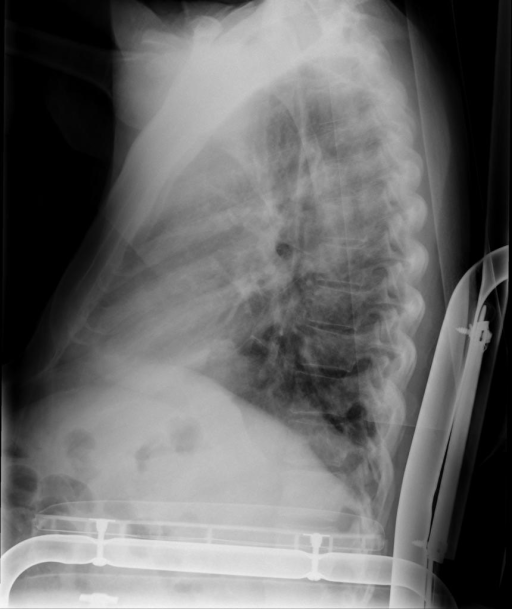

In [ ]:
# check data
print(train_captions[0])
Image.open(image_paths[0])

In [ ]:
image_model.summary()

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
## Make the Image feature Extractor Model
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
'''from tqdm import tqdm

# Get unique images
encode_train = sorted(set(image_paths))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())'''

100%|██████████| 181/181 [00:53<00:00,  3.41it/s]


In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# Max word count for a caption.
max_length = 100
# Use the top 1000 words for a vocabulary.
vocabulary_size = 1000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [ ]:
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
for vector in cap_vector:
  print(vector)
  print(vector.shape)
  break

tf.Tensor(
[ 9  8  6  2 58 31 12 39 22  4 24 11 25 16  5  3 28 83 16  5  3 23 29 16
  4  3 18 14 48 13 19 16  5  3 68 14 15 10  7  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0], shape=(100,), dtype=int64)
(100,)


In [ ]:
## Create word to tokens and tokens to words mapping 
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
## Split data to training and testing 
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(image_paths, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 8:2 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(2312, 2312, 578, 578)

**Create tf datasets**

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 512
units = 1024
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 2560
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

**Creating model**

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)


checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

**Start train**

In [ ]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 21

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 0.5524
Epoch 1 Loss 0.601662
Time taken for 1 epoch 30.77 sec

Epoch 2 Batch 0 Loss 0.6718
Epoch 2 Loss 0.589933
Time taken for 1 epoch 30.02 sec

Epoch 3 Batch 0 Loss 0.5552
Epoch 3 Loss 0.569064
Time taken for 1 epoch 29.98 sec

Epoch 4 Batch 0 Loss 0.4847
Epoch 4 Loss 0.545482
Time taken for 1 epoch 30.32 sec

Epoch 5 Batch 0 Loss 0.4352
Epoch 5 Loss 0.530359
Time taken for 1 epoch 29.73 sec

Epoch 6 Batch 0 Loss 0.4744
Epoch 6 Loss 0.503660
Time taken for 1 epoch 30.28 sec

Epoch 7 Batch 0 Loss 0.4139
Epoch 7 Loss 0.471447
Time taken for 1 epoch 29.95 sec

Epoch 8 Batch 0 Loss 0.4360
Epoch 8 Loss 0.451778
Time taken for 1 epoch 29.87 sec

Epoch 9 Batch 0 Loss 0.4088
Epoch 9 Loss 0.435346
Time taken for 1 epoch 29.73 sec

Epoch 10 Batch 0 Loss 0.3714
Epoch 10 Loss 0.411106
Time taken for 1 epoch 29.87 sec

Epoch 11 Batch 0 Loss 0.3512
Epoch 11 Loss 0.376809
Time taken for 1 epoch 30.24 sec

Epoch 12 Batch 0 Loss 0.4105
Epoch 12 Loss 0.350580
Time taken for 1 epo

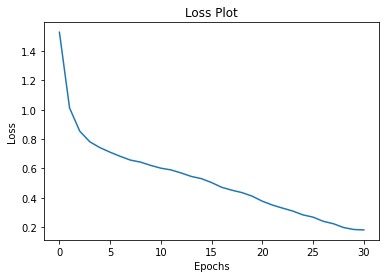

In [ ]:
# draw plot for training curve
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
# backup checkpoint
import shutil

shutil.copytree('./checkpoints', '/content/drive/MyDrive/Colab Notebooks/xray/checkpoints')

'/content/drive/MyDrive/Colab Notebooks/xray/checkpoints'

**Evaluation**

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)
        
        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: start startseq findings [UNK] [UNK] over the mid abdomen there are multiple [UNK] dilated loops of small bowel measuring the xxxx of which measure up to [UNK] [UNK] cm in diameter there is also an extremely dilated xxxx in the same region which measures [UNK] cm in diameter there is extensive soft tissue pannus prior abdominal surgery chest there is xxxx left basilar opacity no visualized pneumothorax the heart size is normal there is mild elevation of the left hemidiaphragm there are no large pleural effusions there is thickening of the fissure endseq end
Prediction Caption: [UNK] over the left upper lobe nodule in the left lower lobe a healing fracture xxxx endseq end or effusion endseq end or pleural effusion bony structures and 8th vertebral body endseq end or effusion interval scarring no acute bony abnormality endseq end or effusion osseous structures are intact endseq end or pleural effusion cardio mediastinal silhouette is normal in size and pulmonary vascularity 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  from ipykernel import kernelapp as app


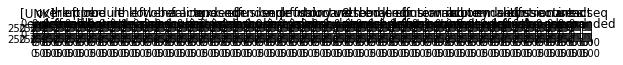

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Real Caption: start startseq findings lungs are clear bilaterally cardiac and mediastinal silhouettes are normal pulmonary vasculature is normal no pneumothorax or pleural effusion no acute bony abnormality endseq end
Prediction Caption: airspace opacities the thoracic aorta is tortuous and posterior pulmonary vascular congestion and the thoracic aorta versus scarring there is no pneumothorax or pleural effusion the lungs are clear thoracic spondylosis there are no pneumothorax the heart size and mediastinal silhouette and mild basilar airspace opacities the thoracic spine osteopenia mild degenerative changes of the thoracic spine osteopenia mild degenerative changes of the left midlung endseq end or [UNK] the thoracic spine osteophytes mild markings throughout the lungs are clear thoracic spondylosis bilateral posterior costophrenic xxxx and tortuous thoracic aorta are overall enlarged heart size and pulmonary consolidation no pleural
Real Caption: start startseq findings cardiac and 

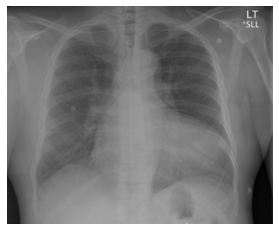

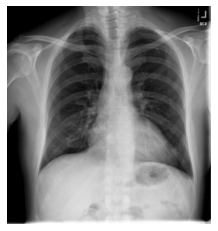

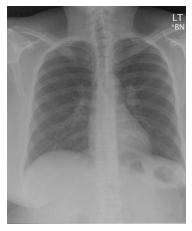

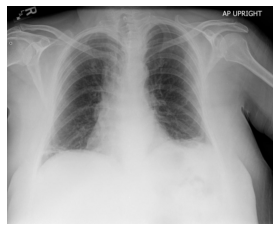

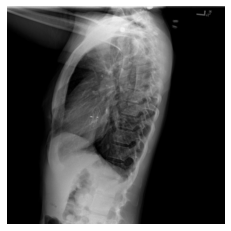

In [ ]:
real_captions = []
predicted_captions = []
for i in range(5):
  # captions on the validation se
  rid = np.random.randint(0, len(img_name_val))
  image = img_name_val[rid]
  real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
  result, attention_plot = evaluate(image)
  pred_cap = ' '.join(result)
  print('Real Caption:', real_caption)
  real_captions.append(real_caption)
  print('Prediction Caption:', ' '.join(result))
  predicted_captions.append(pred_cap)
  img = plt.imread(image)
  plt.figure()
  plt.imshow(img, cmap = "gray")
  plt.axis(False)